<a href="https://colab.research.google.com/github/Vaibhavishinde07/summeranalyticsweek1/blob/main/mars2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install noisereduce

In [3]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D,
                                   GlobalMaxPooling1D, GlobalAveragePooling1D,
                                   BatchNormalization, Activation, Input, concatenate,
                                   Conv2D, MaxPooling2D, Flatten, Reshape, TimeDistributed,
                                   MultiHeadAttention, LayerNormalization, Add)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet101V2

# Machine Learning Tools
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Audio Processing Libraries
import soundfile as sf
from scipy import signal
from scipy.stats import skew, kurtosis
import noisereduce as nr

# Visualization Tools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utility Libraries
import pickle
import json
from tqdm import tqdm
import random
from collections import Counter
import gc

# Configure Random Seeds for Reproducibility
np.random.seed(2023)
tf.random.set_seed(2023)
random.seed(2023)

print("✓ All dependencies loaded successfully!")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Librosa Version: {librosa.__version__}")

✓ All dependencies loaded successfully!
TensorFlow Version: 2.18.0
Librosa Version: 0.11.0


In [4]:
class AdvancedRAVDESSLoader:
    def __init__(self, data_paths):
        self.data_paths = data_paths
        self.emotion_mapping = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad',
                               '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'}
        self.modality_mapping = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
        self.vocal_type_mapping = {'01': 'speech', '02': 'song'}
        self.intensity_mapping = {'01': 'normal', '02': 'strong'}
        self.statement_mapping = {'01': 'kids', '02': 'dogs'}

    def decode_filename_structure(self, file_name):
        """Advanced filename parsing with comprehensive metadata extraction"""
        components = os.path.splitext(file_name)[0].split('-')
        performer_id = int(components[6])

        return {
            'modality_code': components[0],
            'modality_type': self.modality_mapping.get(components[0], 'unknown'),
            'vocal_code': components[1],
            'vocal_type': self.vocal_type_mapping.get(components[1], 'unknown'),
            'emotion_code': components[2],
            'emotion_label': self.emotion_mapping[components[2]],
            'intensity_code': components[3],
            'intensity_type': self.intensity_mapping.get(components[3], 'unknown'),
            'statement_code': components[4],
            'statement_type': self.statement_mapping.get(components[4], 'unknown'),
            'repetition_number': components[5],
            'performer_id': performer_id,
            'performer_gender': 'female' if performer_id % 2 == 0 else 'male'
        }

    def compile_dataset(self):
        """Compile comprehensive dataset with enhanced metadata"""
        data_records = []

        for channel_type, data_root in self.data_paths.items():
            print(f"Processing {channel_type} samples from {data_root}")

            if not os.path.exists(data_root):
                print(f"Warning: Path {data_root} not found!")
                continue

            for performer_dir in tqdm(os.listdir(data_root), desc=f"Loading {channel_type}"):
                performer_path = os.path.join(data_root, performer_dir)
                if not os.path.isdir(performer_path):
                    continue

                for audio_file in os.listdir(performer_path):
                    if audio_file.endswith(('.wav', '.mp4')):
                        try:
                            metadata = self.decode_filename_structure(audio_file)
                            metadata.update({
                                'channel_type': channel_type,
                                'performer_directory': performer_dir,
                                'full_path': os.path.join(performer_path, audio_file),
                                'audio_filename': audio_file
                            })
                            data_records.append(metadata)
                        except Exception as error:
                            print(f"Error processing {audio_file}: {error}")

        dataset = pd.DataFrame(data_records)
        print(f"Dataset compilation complete! Total samples: {dataset.shape}")
        return dataset

In [5]:
audio_data_paths = {
    'speech': r"/content/drive/MyDrive/Audio_Speech_Actors_01-24",
    'song': r"/content/drive/MyDrive/Audio_Song_Actors_01-24"
}

data_loader = AdvancedRAVDESSLoader(audio_data_paths)
emotion_dataset = data_loader.compile_dataset()

print("\n Dataset Analysis:")
print(f"Total audio samples: {len(emotion_dataset)}")
print(f"Unique emotions: {emotion_dataset['emotion_label'].unique()}")
print(f"Channel types: {emotion_dataset['channel_type'].unique()}")
print(f"Number of performers: {emotion_dataset['performer_id'].nunique()}")

# Emotion class distribution analysis
emotion_distribution = emotion_dataset['emotion_label'].value_counts()
print(f"\n Emotion Class Distribution:")
for emotion_class, sample_count in emotion_distribution.items():
    print(f"{emotion_class}: {sample_count}")

# Preview dataset structure
print("\n Dataset Preview (First 5 rows):")
print(emotion_dataset.head())


Processing speech samples from /content/drive/MyDrive/Audio_Speech_Actors_01-24


Loading speech: 100%|██████████| 24/24 [00:04<00:00,  5.03it/s]


Processing song samples from /content/drive/MyDrive/Audio_Song_Actors_01-24


Loading song: 100%|██████████| 23/23 [00:03<00:00,  6.47it/s]

Error processing 03-02-05-01-02-01-12 (1).wav: invalid literal for int() with base 10: '12 (1)'
Error processing 03-02-05-01-02-02-12 (1).wav: invalid literal for int() with base 10: '12 (1)'
Error processing 03-02-05-02-01-01-12 (1).wav: invalid literal for int() with base 10: '12 (1)'
Error processing 03-02-05-02-01-02-12 (1).wav: invalid literal for int() with base 10: '12 (1)'
Error processing 03-02-05-02-02-01-12 (1).wav: invalid literal for int() with base 10: '12 (1)'
Dataset compilation complete! Total samples: (2452, 17)

 Dataset Analysis:
Total audio samples: 2452
Unique emotions: ['surprised' 'sad' 'happy' 'neutral' 'disgust' 'calm' 'fearful' 'angry']
Channel types: ['speech' 'song']
Number of performers: 24

 Emotion Class Distribution:
sad: 376
happy: 376
fearful: 376
calm: 376
angry: 376
surprised: 192
disgust: 192
neutral: 188

 Dataset Preview (First 5 rows):
  modality_code modality_type vocal_code vocal_type emotion_code  \
0            03    audio-only         01   

In [6]:
class EnhancedAudioFeatureExtractor:
    def __init__(self, sampling_rate=22050, audio_duration=3.0, mfcc_coefficients=13, mel_bands=64):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.mfcc_coefficients = mfcc_coefficients
        self.mel_bands = mel_bands
        self.target_length = int(sampling_rate * audio_duration)

    def load_and_normalize_audio(self, audio_path, noise_reduction=False):
        """Load and normalize audio with optional noise reduction"""
        try:
            # Load audio signal
            audio_signal, sr = librosa.load(audio_path, sr=self.sampling_rate, duration=self.audio_duration)

            # Ensure consistent length
            if len(audio_signal) < self.target_length:
                audio_signal = np.pad(audio_signal, (0, self.target_length - len(audio_signal)), mode='constant')
            else:
                audio_signal = audio_signal[:self.target_length]

            # Apply noise reduction if requested
            if noise_reduction:
                audio_signal = nr.reduce_noise(y=audio_signal, sr=sr, prop_decrease=0.8)

            # Apply normalization
            audio_signal = librosa.util.normalize(audio_signal)

            return audio_signal, sr

        except Exception as error:
            print(f"Audio loading error for {audio_path}: {error}")
            return np.zeros(self.target_length), self.sampling_rate

    def compute_mfcc_features(self, audio_signal, sr):
        """Compute comprehensive MFCC feature set"""
        mfcc_features = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=self.mfcc_coefficients)

        # Statistical aggregations
        mfcc_means = np.mean(mfcc_features, axis=1)
        mfcc_stds = np.std(mfcc_features, axis=1)
        mfcc_first_deltas = np.mean(librosa.feature.delta(mfcc_features), axis=1)
        mfcc_second_deltas = np.mean(librosa.feature.delta(mfcc_features, order=2), axis=1)

        # Combine all features
        combined_features = np.concatenate([mfcc_means, mfcc_stds, mfcc_first_deltas, mfcc_second_deltas])

        return combined_features

    def generate_mel_spectrogram(self, audio_path):
        """Generate mel-spectrogram for CNN processing"""
        audio_signal, sr = self.load_and_normalize_audio(audio_path)

        # Compute mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_signal, sr=sr, n_mels=self.mel_bands, fmax=8000
        )
        mel_spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Normalize to [0, 1] range
        normalized_mel_spec = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

        return normalized_mel_spec

    def extract_temporal_features(self, audio_path, time_frames=128):
        """Extract temporal features for sequence modeling"""
        audio_signal, sr = self.load_and_normalize_audio(audio_path)

        # Extract MFCC sequences
        mfcc_sequence = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=self.mfcc_coefficients)

        # Ensure consistent frame count
        if mfcc_sequence.shape[1] < time_frames:
            mfcc_sequence = np.pad(mfcc_sequence, ((0, 0), (0, time_frames - mfcc_sequence.shape[1])), mode='constant')
        else:
            mfcc_sequence = mfcc_sequence[:, :time_frames]

        # Transpose for temporal modeling (time_steps, features)
        return mfcc_sequence.T


In [7]:
class SmartAudioAugmentation:
    def __init__(self, sampling_rate=22050):
        self.sampling_rate = sampling_rate

    def inject_gaussian_noise(self, audio_signal, noise_intensity=0.003):
        """Inject controlled Gaussian noise"""
        return audio_signal + noise_intensity * np.random.randn(len(audio_signal))

    def apply_time_stretching(self, audio_signal, stretch_factor=None):
        """Apply controlled time stretching"""
        if stretch_factor is None:
            stretch_factor = np.random.uniform(0.85, 1.15)
        return librosa.effects.time_stretch(audio_signal, rate=stretch_factor)

    def apply_pitch_shifting(self, audio_signal, semitone_shift=None):
        """Apply controlled pitch shifting"""
        if semitone_shift is None:
            semitone_shift = np.random.randint(-3, 4)
        return librosa.effects.pitch_shift(audio_signal, sr=self.sampling_rate, n_steps=semitone_shift)

    def apply_random_augmentation(self, audio_signal):
        """Apply random augmentation technique"""
        augmentation_methods = [self.inject_gaussian_noise, self.apply_time_stretching, self.apply_pitch_shifting]
        selected_method = np.random.choice(augmentation_methods)
        return selected_method(audio_signal)

In [8]:
def extract_balanced_features(dataset, feature_extractor, enable_augmentation=True):
    """Extract features with intelligent class balancing"""

    # Analyze class imbalance
    class_distribution = dataset['emotion_label'].value_counts()
    max_samples = class_distribution.max()

    cnn_feature_list = []
    lstm_feature_list = []
    label_list = []

    augmentation_engine = SmartAudioAugmentation()

    print(" Extracting features with intelligent class balancing...")

    for emotion_class in class_distribution.index:
        class_subset = dataset[dataset['emotion_label'] == emotion_class]
        current_samples = len(class_subset)

        print(f"Processing {emotion_class}: {current_samples} samples")

        # Process original samples
        for idx, sample_row in class_subset.iterrows():
            try:
                # Extract multi-modal features
                cnn_features = feature_extractor.generate_mel_spectrogram(sample_row['full_path'])
                lstm_features = feature_extractor.extract_temporal_features(sample_row['full_path'])

                cnn_feature_list.append(cnn_features)
                lstm_feature_list.append(lstm_features)
                label_list.append(sample_row['emotion_label'])

                # Generate augmented samples for minority classes
                if enable_augmentation and current_samples < max_samples * 0.75:
                    # Load original audio for augmentation
                    original_audio, sample_rate = feature_extractor.load_and_normalize_audio(sample_row['full_path'])

                    # Calculate augmentation count
                    augmentation_count = min(2, int((max_samples * 0.75 - current_samples) / current_samples) + 1)

                    for aug_iter in range(augmentation_count):
                        # Generate augmented version
                        augmented_audio = augmentation_engine.apply_random_augmentation(original_audio)

                        # Create temporary file for feature extraction
                        temp_file_path = f"temp_augmented_{idx}_{aug_iter}.wav"
                        sf.write(temp_file_path, augmented_audio, sample_rate)

                        augmented_cnn_features = feature_extractor.generate_mel_spectrogram(temp_file_path)
                        augmented_lstm_features = feature_extractor.extract_temporal_features(temp_file_path)

                        cnn_feature_list.append(augmented_cnn_features)
                        lstm_feature_list.append(augmented_lstm_features)
                        label_list.append(sample_row['emotion_label'])

                        # Clean up temporary file
                        if os.path.exists(temp_file_path):
                            os.remove(temp_file_path)

            except Exception as error:
                print(f"Feature extraction error for {sample_row['full_path']}: {error}")
                continue

    return np.array(cnn_feature_list), np.array(lstm_feature_list), np.array(label_list)


In [9]:
# Initialize feature extraction system
audio_processor = EnhancedAudioFeatureExtractor()

# Perform stratified train-test split (80-20)
training_data, testing_data = train_test_split(
    emotion_dataset, test_size=0.20, random_state=2023,
    stratify=emotion_dataset['emotion_label']
)

print(f" Data split complete:")
print(f"Training samples: {len(training_data)}")
print(f"Testing samples: {len(testing_data)}")

# Extract features for training set (with augmentation)
train_cnn_features, train_lstm_features, train_labels = extract_balanced_features(
    training_data, audio_processor, enable_augmentation=True
)

# Extract features for test set (without augmentation)
test_cnn_features, test_lstm_features, test_labels = extract_balanced_features(
    testing_data, audio_processor, enable_augmentation=False
)

print(f" Feature extraction summary:")
print(f"Training CNN features shape: {train_cnn_features.shape}")
print(f"Training LSTM features shape: {train_lstm_features.shape}")
print(f"Testing CNN features shape: {test_cnn_features.shape}")
print(f"Testing LSTM features shape: {test_lstm_features.shape}")

 Data split complete:
Training samples: 1961
Testing samples: 491
 Extracting features with intelligent class balancing...
Processing angry: 301 samples
Processing fearful: 301 samples
Processing happy: 301 samples
Processing sad: 301 samples
Processing calm: 301 samples
Processing surprised: 153 samples
Processing disgust: 153 samples
Processing neutral: 150 samples
 Extracting features with intelligent class balancing...
Processing angry: 75 samples
Processing happy: 75 samples
Processing fearful: 75 samples
Processing sad: 75 samples
Processing calm: 75 samples
Processing disgust: 39 samples
Processing surprised: 39 samples
Processing neutral: 38 samples
 Feature extraction summary:
Training CNN features shape: (2417, 64, 130)
Training LSTM features shape: (2417, 128, 13)
Testing CNN features shape: (491, 64, 130)
Testing LSTM features shape: (491, 128, 13)


In [10]:
# Initialize label encoding
from keras.layers import GlobalAveragePooling2D
emotion_encoder = LabelEncoder()
encoded_train_labels = emotion_encoder.fit_transform(train_labels)
encoded_test_labels = emotion_encoder.transform(test_labels)
total_classes = len(emotion_encoder.classes_)

# Convert to categorical format
categorical_train_labels = to_categorical(encoded_train_labels, total_classes)
categorical_test_labels = to_categorical(encoded_test_labels, total_classes)

# Prepare RGB format for pre-trained models
train_cnn_rgb = np.repeat(train_cnn_features[..., np.newaxis], 3, axis=-1)
test_cnn_rgb = np.repeat(test_cnn_features[..., np.newaxis], 3, axis=-1)

# Resize spectrograms for ResNet101 compatibility
def resize_spectrograms_for_resnet(spectrogram_data, target_dimensions=(224, 224)):
    """Resize spectrograms for ResNet101 input requirements"""
    from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
    from PIL import Image

    resized_data = []
    for idx in range(spectrogram_data.shape[0]):
        # Convert to PIL Image and resize
        image = array_to_img(spectrogram_data[idx])
        resized_image = image.resize(target_dimensions)
        image_array = img_to_array(resized_image)
        resized_data.append(image_array)

    return np.array(resized_data) / 255.0  # Normalize to [0,1]

train_resnet_features = resize_spectrograms_for_resnet(train_cnn_rgb)
test_resnet_features = resize_spectrograms_for_resnet(test_cnn_rgb)

# Compute class weights for imbalance handling
balanced_class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(encoded_train_labels),
    y=encoded_train_labels
)
class_weight_mapping = dict(enumerate(balanced_class_weights))

print(f"Label processing complete:")
print(f"Total emotion classes: {total_classes}")
print(f"Emotion classes: {emotion_encoder.classes_}")
print(f"Class weights: {class_weight_mapping}")

# Final training distribution
print("\n Final training class distribution:")
final_train_distribution = Counter(train_labels)
for emotion, count in final_train_distribution.items():
    print(f"{emotion}: {count}")


Label processing complete:
Total emotion classes: 8
Emotion classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Class weights: {0: np.float64(1.0037375415282392), 1: np.float64(1.0037375415282392), 2: np.float64(0.9873366013071896), 3: np.float64(1.0037375415282392), 4: np.float64(1.0037375415282392), 5: np.float64(1.0070833333333333), 6: np.float64(1.0037375415282392), 7: np.float64(0.9873366013071896)}

 Final training class distribution:
angry: 301
fearful: 301
happy: 301
sad: 301
calm: 301
surprised: 306
disgust: 306
neutral: 300


In [11]:
def create_training_callbacks(model_identifier):
    """Create comprehensive training callbacks"""
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=25,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=7,
            min_lr=1e-4,
            verbose=1
        ),
        ModelCheckpoint(
            f'optimal_{model_identifier}_weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

# Training hyperparameters
training_batch_size = 32
training_epochs = 100


In [13]:
from keras.layers import GlobalAveragePooling2D
def create_resnet101_emotion_model(input_dimensions, num_classes):
    """Create ResNet101-based emotion recognition model"""

    # Load pre-trained ResNet101V2
    base_resnet = ResNet101V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_dimensions
    )

    # Freeze pre-trained layers
    base_resnet.trainable = False

    # Add custom classification layers
    emotion_model = Sequential([
        base_resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return emotion_model

# Create and compile ResNet101 model
resnet101_model = create_resnet101_emotion_model(
    input_dimensions=train_resnet_features.shape[1:],
    num_classes=total_classes
)

resnet101_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" ResNet101 Model Architecture:")
resnet101_model.summary()


 ResNet101 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 7, 7, 2048)     │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,071,688 (168.12 MB)

 Trainable params: 1,445,128 (5.51 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

In [14]:
print(" Training ResNet101 Model...")


resnet101_training_history = resnet101_model.fit(
    train_resnet_features,
    categorical_train_labels,
    batch_size=training_batch_size,
    epochs=training_epochs,
    validation_data=(test_resnet_features, categorical_test_labels),
    callbacks=create_training_callbacks('resnet101'),
    class_weight=class_weight_mapping,
    verbose=1
)


 Training ResNet101 Model...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1746 - loss: 2.0944
Epoch 1: val_accuracy improved from -inf to 0.31976, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 489ms/step - accuracy: 0.1752 - loss: 2.0931 - val_accuracy: 0.3198 - val_loss: 1.7786 - learning_rate: 1.0000e-04
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3310 - loss: 1.7639
Epoch 2: val_accuracy improved from 0.31976 to 0.37678, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.3313 - loss: 1.7633 - val_accuracy: 0.3768 - val_loss: 1.6446 - learning_rate: 1.0000e-04
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4010 - loss: 1.5957
Epoch 3: val_accuracy improved from 0.37678 to 0.39919, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.4013 - loss: 1.5954 - val_accuracy: 0.3992 - val_loss: 1.5615 - learning_rate: 1.0000e-04
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4536 - loss: 1.4733
Epoch 4: val_accuracy improved from 0.39919 to 0.43788, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.4537 - loss: 1.4729 - val_accuracy: 0.4379 - val_loss: 1.4835 - learning_rate: 1.0000e-04
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4897 - loss: 1.3670
Epoch 5: val_accuracy improved from 0.43788 to 0.45214, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.4898 - loss: 1.3669 - val_accuracy: 0.4521 - val_loss: 1.4362 - learning_rate: 1.0000e-04
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5364 - loss: 1.2617
Epoch 6: val_accuracy improved from 0.45214 to 0.48473, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.5364 - loss: 1.2616 - val_accuracy: 0.4847 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5618 - loss: 1.1930
Epoch 7: val_accuracy improved from 0.48473 to 0.49898, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.5619 - loss: 1.1928 - val_accuracy: 0.4990 - val_loss: 1.3705 - learning_rate: 1.0000e-04
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6074 - loss: 1.1009
Epoch 8: val_accuracy improved from 0.49898 to 0.50305, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.6075 - loss: 1.1009 - val_accuracy: 0.5031 - val_loss: 1.3375 - learning_rate: 1.0000e-04
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6293 - loss: 1.0370
Epoch 9: val_accuracy improved from 0.50305 to 0.50509, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.6293 - loss: 1.0368 - val_accuracy: 0.5051 - val_loss: 1.3230 - learning_rate: 1.0000e-04
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6467 - loss: 0.9662
Epoch 10: val_accuracy did not improve from 0.50509
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.6467 - loss: 0.9660 - val_accuracy: 0.5031 - val_loss: 1.3220 - learning_rate: 1.0000e-04
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6579 - loss: 0.9214
Epoch 11: val_accuracy improved from 0.50509 to 0.52138, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step - accuracy: 0.6580 - loss: 0.9210 - val_accuracy: 0.5214 - val_loss: 1.2867 - learning_rate: 1.0000e-04
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6950 - loss: 0.8364
Epoch 12: val_accuracy improved from 0.52138 to 0.52749, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.6951 - loss: 0.8362 - val_accuracy: 0.5275 - val_loss: 1.2682 - learning_rate: 1.0000e-04
Epoch 13/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7260 - loss: 0.7830
Epoch 13: val_accuracy did not improve from 0.52749
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.7260 - loss: 0.7827 - val_accuracy: 0.5234 - val_loss: 1.2733 - learning_rate: 1.0000e-04
Epoch 14/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7464 - loss: 0.7211
Epoch 14: val_accuracy did not improve from 0.52749
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.7466 - loss: 0.7206 - val_accuracy: 0.5193 - val_loss: 1.2795 - learning_rate: 1.0000e-04
Epoch 15/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7558 - loss: 0.6695
Epoch 15: val_accuracy improved from 0.52749 to 0.53768, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.7561 - loss: 0.6691 - val_accuracy: 0.5377 - val_loss: 1.2804 - learning_rate: 1.0000e-04
Epoch 16/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7850 - loss: 0.6069
Epoch 16: val_accuracy did not improve from 0.53768
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.7852 - loss: 0.6064 - val_accuracy: 0.5316 - val_loss: 1.2741 - learning_rate: 1.0000e-04
Epoch 17/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8005 - loss: 0.5635
Epoch 17: val_accuracy improved from 0.53768 to 0.54990, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - accuracy: 0.8006 - loss: 0.5631 - val_accuracy: 0.5499 - val_loss: 1.2767 - learning_rate: 1.0000e-04
Epoch 18/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8482 - loss: 0.4868
Epoch 18: val_accuracy improved from 0.54990 to 0.55804, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8482 - loss: 0.4866 - val_accuracy: 0.5580 - val_loss: 1.3164 - learning_rate: 1.0000e-04
Epoch 19/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8543 - loss: 0.4448
Epoch 19: val_accuracy improved from 0.55804 to 0.56619, saving model to optimal_resnet101_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8544 - loss: 0.4446 - val_accuracy: 0.5662 - val_loss: 1.2962 - learning_rate: 1.0000e-04
Epoch 20/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8770 - loss: 0.3854
Epoch 20: val_accuracy did not improve from 0.56619
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.8771 - loss: 0.3852 - val_accuracy: 0.5479 - val_loss: 1.3098 - learning_rate: 1.0000e-04
Epoch 21/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8960 - loss: 0.3588
Epoch 21: val_accuracy did not improve from 0.56619
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.8960 - loss: 0.3586 - val_accuracy: 0.5642 - val_loss: 1.3092 - learning_rate: 1.0000e-04
Epoch 22/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9001 - loss: 0.3301
Epoch 22: val_accuracy did not improve from 0.56619
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.9002 - loss: 0.3298 - val_accuracy: 0.5662 - val_loss: 1.3380 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.9186 - loss: 0.2795 - val_accuracy: 0.5784 - val_loss: 1.3503 - learning_rate: 1.0000e-04
Epoch 24/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9182 - loss: 0.2507
Epoch 24: val_accuracy did not improve from 0.57841
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.9183 - loss: 0.2506 - val_accuracy: 0.5519 - val_loss: 1.4095 - learning_rate: 1.0000e-04
Epoch 25/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9385 - loss: 0.2190
Epoch 25: val_accuracy did not improve from 0.57841
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9385 - loss: 0.2190 - val_accuracy: 0.5621 - val_loss: 1.3874 - learning_rate: 1.0000e-04
Epoch 26/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9501 - loss: 0.1858
Epoch 26: val_accuracy did not improve from 0.57841
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.9501 - loss: 0.1856 - val_accuracy: 0.5723 - val_loss: 1.4517 - learning_rate: 1.0000e

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

def create_vgg16_emotion_model(input_dimensions, num_classes):
    """Create VGG16-based emotion recognition model"""

    # Load pre-trained VGG16
    base_vgg16 = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_dimensions
    )

    # Freeze pre-trained layers
    base_vgg16.trainable = False

    # Add custom classification layers
    emotion_model = Sequential([
        base_vgg16,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return emotion_model

# Create and compile VGG16 model
vgg16_model = create_vgg16_emotion_model(
    input_dimensions=train_resnet_features.shape[1:],
    num_classes=total_classes
)

vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" VGG16 Model Architecture:")
vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
 VGG16 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,373,384 (58.64 MB)

 Trainable params: 658,696 (2.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
def create_vgg19_emotion_model(input_dimensions, num_classes):
    """Create VGG19-based emotion recognition model"""

    # Load pre-trained VGG19
    base_vgg19 = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=input_dimensions
    )

    # Freeze pre-trained layers
    base_vgg19.trainable = False

    # Add custom classification layers
    emotion_model = Sequential([
        base_vgg19,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return emotion_model

# Create and compile VGG19 model
vgg19_model = create_vgg19_emotion_model(
    input_dimensions=train_resnet_features.shape[1:],
    num_classes=total_classes
)

vgg19_model.compile(
    optimizer=Adam(learning_rate=0.0001155),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" VGG19 Model Architecture:")
vgg19_model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
 VGG19 Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,683,080 (78.90 MB)

 Trainable params: 658,696 (2.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [17]:
vgg16_training_history = vgg16_model.fit(
    train_resnet_features,
    categorical_train_labels,
    batch_size=training_batch_size,
    epochs=training_epochs,
    validation_data=(test_resnet_features, categorical_test_labels),
    callbacks=create_training_callbacks('vgg16'),
    class_weight=class_weight_mapping,
    verbose=1
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.1284 - loss: 2.1192
Epoch 1: val_accuracy improved from -inf to 0.11813, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - accuracy: 0.1285 - loss: 2.1191 - val_accuracy: 0.1181 - val_loss: 2.0850 - learning_rate: 1.0000e-04
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.1426 - loss: 2.0727
Epoch 2: val_accuracy improved from 0.11813 to 0.22403, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - accuracy: 0.1427 - loss: 2.0726 - val_accuracy: 0.2240 - val_loss: 2.0405 - learning_rate: 1.0000e-04
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.1941 - loss: 2.0346
Epoch 3: val_accuracy improved from 0.22403 to 0.29124, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.1942 - loss: 2.0344 - val_accuracy: 0.2912 - val_loss: 1.9858 - learning_rate: 1.0000e-04
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2049 - loss: 1.9767
Epoch 4: val_accuracy improved from 0.29124 to 0.30346, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.2053 - loss: 1.9764 - val_accuracy: 0.3035 - val_loss: 1.9055 - learning_rate: 1.0000e-04
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2593 - loss: 1.8955
Epoch 5: val_accuracy did not improve from 0.30346
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.2596 - loss: 1.8951 - val_accuracy: 0.3035 - val_loss: 1.8444 - learning_rate: 1.0000e-04
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2933 - loss: 1.8124
Epoch 6: val_accuracy improved from 0.30346 to 0.31772, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.2935 - loss: 1.8121 - val_accuracy: 0.3177 - val_loss: 1.7828 - learning_rate: 1.0000e-04
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3324 - loss: 1.7306
Epoch 7: val_accuracy improved from 0.31772 to 0.32790, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.3327 - loss: 1.7303 - val_accuracy: 0.3279 - val_loss: 1.7361 - learning_rate: 1.0000e-04
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3403 - loss: 1.6834
Epoch 8: val_accuracy improved from 0.32790 to 0.36049, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.3404 - loss: 1.6831 - val_accuracy: 0.3605 - val_loss: 1.6891 - learning_rate: 1.0000e-04
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3855 - loss: 1.6151
Epoch 9: val_accuracy improved from 0.36049 to 0.37271, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.3855 - loss: 1.6150 - val_accuracy: 0.3727 - val_loss: 1.6477 - learning_rate: 1.0000e-04
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3986 - loss: 1.5811
Epoch 10: val_accuracy improved from 0.37271 to 0.38086, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.3987 - loss: 1.5810 - val_accuracy: 0.3809 - val_loss: 1.6101 - learning_rate: 1.0000e-04
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4047 - loss: 1.5269
Epoch 11: val_accuracy improved from 0.38086 to 0.38900, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.4049 - loss: 1.5269 - val_accuracy: 0.3890 - val_loss: 1.5769 - learning_rate: 1.0000e-04
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4271 - loss: 1.5098
Epoch 12: val_accuracy improved from 0.38900 to 0.39511, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.4271 - loss: 1.5097 - val_accuracy: 0.3951 - val_loss: 1.5561 - learning_rate: 1.0000e-04
Epoch 13/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4520 - loss: 1.4516
Epoch 13: val_accuracy improved from 0.39511 to 0.39919, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.4521 - loss: 1.4515 - val_accuracy: 0.3992 - val_loss: 1.5296 - learning_rate: 1.0000e-04
Epoch 14/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4622 - loss: 1.4356
Epoch 14: val_accuracy improved from 0.39919 to 0.41344, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.4622 - loss: 1.4356 - val_accuracy: 0.4134 - val_loss: 1.5061 - learning_rate: 1.0000e-04
Epoch 15/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4740 - loss: 1.4187
Epoch 15: val_accuracy improved from 0.41344 to 0.41752, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.4740 - loss: 1.4186 - val_accuracy: 0.4175 - val_loss: 1.4914 - learning_rate: 1.0000e-04
Epoch 16/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4736 - loss: 1.3860
Epoch 16: val_accuracy improved from 0.41752 to 0.42159, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.4736 - loss: 1.3860 - val_accuracy: 0.4216 - val_loss: 1.4781 - learning_rate: 1.0000e-04
Epoch 17/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4784 - loss: 1.3724
Epoch 17: val_accuracy improved from 0.42159 to 0.43585, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.4785 - loss: 1.3724 - val_accuracy: 0.4358 - val_loss: 1.4633 - learning_rate: 1.0000e-04
Epoch 18/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4930 - loss: 1.3504
Epoch 18: val_accuracy improved from 0.43585 to 0.43788, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.4930 - loss: 1.3504 - val_accuracy: 0.4379 - val_loss: 1.4409 - learning_rate: 1.0000e-04
Epoch 19/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4906 - loss: 1.3308
Epoch 19: val_accuracy improved from 0.43788 to 0.45621, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.4906 - loss: 1.3308 - val_accuracy: 0.4562 - val_loss: 1.4255 - learning_rate: 1.0000e-04
Epoch 20/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5001 - loss: 1.3072
Epoch 20: val_accuracy did not improve from 0.45621
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - accuracy: 0.5001 - loss: 1.3072 - val_accuracy: 0.4481 - val_loss: 1.4081 - learning_rate: 1.0000e-04
Epoch 21/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5102 - loss: 1.2858
Epoch 21: val_accuracy did not improve from 0.45621
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.5102 - loss: 1.2859 - val_accuracy: 0.4521 - val_loss: 1.4028 - learning_rate: 1.0000e-04
Epoch 22/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5274 - loss: 1.2609
Epoch 22: val_accuracy improved from 0.45621 to 0.46843, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.5274 - loss: 1.2610 - val_accuracy: 0.4684 - val_loss: 1.3840 - learning_rate: 1.0000e-04
Epoch 23/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5099 - loss: 1.2544
Epoch 23: val_accuracy improved from 0.46843 to 0.47454, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.5100 - loss: 1.2545 - val_accuracy: 0.4745 - val_loss: 1.3728 - learning_rate: 1.0000e-04
Epoch 24/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5173 - loss: 1.2589
Epoch 24: val_accuracy improved from 0.47454 to 0.49491, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.5174 - loss: 1.2588 - val_accuracy: 0.4949 - val_loss: 1.3574 - learning_rate: 1.0000e-04
Epoch 25/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5304 - loss: 1.2280
Epoch 25: val_accuracy did not improve from 0.49491
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.5303 - loss: 1.2282 - val_accuracy: 0.4868 - val_loss: 1.3600 - learning_rate: 1.0000e-04
Epoch 26/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5342 - loss: 1.2186
Epoch 26: val_accuracy did not improve from 0.49491
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.5342 - loss: 1.2187 - val_accuracy: 0.4949 - val_loss: 1.3462 - learning_rate: 1.0000e-04
Epoch 27/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5534 - loss: 1.1858
Epoch 27: val_accuracy did not improve from 0.49491
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.5534 - loss: 1.1859 - val_accuracy: 0.4949 - val_loss: 1.3370 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.5611 - loss: 1.1565 - val_accuracy: 0.5071 - val_loss: 1.3217 - learning_rate: 1.0000e-04
Epoch 30/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5674 - loss: 1.1363
Epoch 30: val_accuracy did not improve from 0.50713
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5673 - loss: 1.1366 - val_accuracy: 0.5051 - val_loss: 1.3117 - learning_rate: 1.0000e-04
Epoch 31/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5693 - loss: 1.1438
Epoch 31: val_accuracy did not improve from 0.50713
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.5693 - loss: 1.1440 - val_accuracy: 0.4990 - val_loss: 1.3085 - learning_rate: 1.0000e-04
Epoch 32/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5687 - loss: 1.1478
Epoch 32: val_accuracy improved from 0.50713 to 0.51324, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.5688 - loss: 1.1477 - val_accuracy: 0.5132 - val_loss: 1.2897 - learning_rate: 1.0000e-04
Epoch 33/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5555 - loss: 1.1322
Epoch 33: val_accuracy improved from 0.51324 to 0.51731, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - accuracy: 0.5557 - loss: 1.1322 - val_accuracy: 0.5173 - val_loss: 1.2894 - learning_rate: 1.0000e-04
Epoch 34/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5780 - loss: 1.1045
Epoch 34: val_accuracy improved from 0.51731 to 0.52138, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.5780 - loss: 1.1046 - val_accuracy: 0.5214 - val_loss: 1.2799 - learning_rate: 1.0000e-04
Epoch 35/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5935 - loss: 1.0898
Epoch 35: val_accuracy improved from 0.52138 to 0.52546, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.5934 - loss: 1.0898 - val_accuracy: 0.5255 - val_loss: 1.2686 - learning_rate: 1.0000e-04
Epoch 36/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5787 - loss: 1.0812
Epoch 36: val_accuracy did not improve from 0.52546
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.5788 - loss: 1.0813 - val_accuracy: 0.5234 - val_loss: 1.2623 - learning_rate: 1.0000e-04
Epoch 37/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5921 - loss: 1.0777
Epoch 37: val_accuracy did not improve from 0.52546
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.5921 - loss: 1.0777 - val_accuracy: 0.5173 - val_loss: 1.2488 - learning_rate: 1.0000e-04
Epoch 38/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5858 - loss: 1.0848
Epoch 38: val_accuracy did not improve from 0.52546
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.5859 - loss: 1.0848 - val_accuracy: 0.5214 - val_loss: 1.2483 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.5863 - loss: 1.0802 - val_accuracy: 0.5377 - val_loss: 1.2429 - learning_rate: 1.0000e-04
Epoch 40/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6071 - loss: 1.0627
Epoch 40: val_accuracy did not improve from 0.53768
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.6072 - loss: 1.0627 - val_accuracy: 0.5356 - val_loss: 1.2512 - learning_rate: 1.0000e-04
Epoch 41/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6081 - loss: 1.0393
Epoch 41: val_accuracy improved from 0.53768 to 0.53971, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.6080 - loss: 1.0394 - val_accuracy: 0.5397 - val_loss: 1.2379 - learning_rate: 1.0000e-04
Epoch 42/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6015 - loss: 1.0304
Epoch 42: val_accuracy did not improve from 0.53971
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.6016 - loss: 1.0305 - val_accuracy: 0.5295 - val_loss: 1.2457 - learning_rate: 1.0000e-04
Epoch 43/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6045 - loss: 1.0375
Epoch 43: val_accuracy improved from 0.53971 to 0.54990, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.6046 - loss: 1.0374 - val_accuracy: 0.5499 - val_loss: 1.2236 - learning_rate: 1.0000e-04
Epoch 44/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6007 - loss: 1.0285
Epoch 44: val_accuracy improved from 0.54990 to 0.55601, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.6009 - loss: 1.0284 - val_accuracy: 0.5560 - val_loss: 1.2292 - learning_rate: 1.0000e-04
Epoch 45/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6091 - loss: 1.0074
Epoch 45: val_accuracy did not improve from 0.55601
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.6092 - loss: 1.0075 - val_accuracy: 0.5397 - val_loss: 1.2228 - learning_rate: 1.0000e-04
Epoch 46/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6335 - loss: 0.9785
Epoch 46: val_accuracy did not improve from 0.55601
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step - accuracy: 0.6335 - loss: 0.9786 - val_accuracy: 0.5499 - val_loss: 1.2138 - learning_rate: 1.0000e-04
Epoch 47/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6112 - loss: 0.9998
Epoch 47: val_accuracy did not improve from 0.55601
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.6113 - loss: 0.9998 - val_accuracy: 0.5499 - val_loss: 1.2121 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.6397 - loss: 0.9476 - val_accuracy: 0.5580 - val_loss: 1.2026 - learning_rate: 1.0000e-04
Epoch 51/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6317 - loss: 0.9603
Epoch 51: val_accuracy did not improve from 0.55804
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.6317 - loss: 0.9603 - val_accuracy: 0.5479 - val_loss: 1.2071 - learning_rate: 1.0000e-04
Epoch 52/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6374 - loss: 0.9596
Epoch 52: val_accuracy improved from 0.55804 to 0.56212, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.6374 - loss: 0.9595 - val_accuracy: 0.5621 - val_loss: 1.1943 - learning_rate: 1.0000e-04
Epoch 53/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6317 - loss: 0.9452
Epoch 53: val_accuracy did not improve from 0.56212
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.6319 - loss: 0.9451 - val_accuracy: 0.5621 - val_loss: 1.1886 - learning_rate: 1.0000e-04
Epoch 54/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6380 - loss: 0.9303
Epoch 54: val_accuracy improved from 0.56212 to 0.57026, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.6381 - loss: 0.9303 - val_accuracy: 0.5703 - val_loss: 1.1813 - learning_rate: 1.0000e-04
Epoch 55/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6391 - loss: 0.9242
Epoch 55: val_accuracy improved from 0.57026 to 0.57434, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.6391 - loss: 0.9243 - val_accuracy: 0.5743 - val_loss: 1.1789 - learning_rate: 1.0000e-04
Epoch 56/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6408 - loss: 0.9194
Epoch 56: val_accuracy did not improve from 0.57434
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.6409 - loss: 0.9194 - val_accuracy: 0.5621 - val_loss: 1.1812 - learning_rate: 1.0000e-04
Epoch 57/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6486 - loss: 0.9205
Epoch 57: val_accuracy did not improve from 0.57434
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.6486 - loss: 0.9206 - val_accuracy: 0.5621 - val_loss: 1.1835 - learning_rate: 1.0000e-04
Epoch 58/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6615 - loss: 0.8954
Epoch 58: val_accuracy did not improve from 0.57434
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.6615 - loss: 0.8955 - val_accuracy: 0.5621 - val_loss: 1.1733 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.6761 - loss: 0.8547 - val_accuracy: 0.5764 - val_loss: 1.1573 - learning_rate: 1.0000e-04
Epoch 64/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6683 - loss: 0.8649
Epoch 64: val_accuracy did not improve from 0.57637
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.6684 - loss: 0.8649 - val_accuracy: 0.5743 - val_loss: 1.1558 - learning_rate: 1.0000e-04
Epoch 65/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6606 - loss: 0.8709
Epoch 65: val_accuracy did not improve from 0.57637
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.6607 - loss: 0.8707 - val_accuracy: 0.5703 - val_loss: 1.1637 - learning_rate: 1.0000e-04
Epoch 66/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6901 - loss: 0.8397
Epoch 66: val_accuracy did not improve from 0.57637
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.6902 - loss: 0.8396 - val_accuracy: 0.5662 - val_loss: 1.1641 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.6827 - loss: 0.8477 - val_accuracy: 0.5825 - val_loss: 1.1601 - learning_rate: 1.0000e-04
Epoch 69/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6793 - loss: 0.8388
Epoch 69: val_accuracy did not improve from 0.58248
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.6794 - loss: 0.8387 - val_accuracy: 0.5804 - val_loss: 1.1455 - learning_rate: 1.0000e-04
Epoch 70/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6918 - loss: 0.8147
Epoch 70: val_accuracy improved from 0.58248 to 0.58859, saving model to optimal_vgg16_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.6918 - loss: 0.8147 - val_accuracy: 0.5886 - val_loss: 1.1474 - learning_rate: 1.0000e-04
Epoch 71/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6897 - loss: 0.8111
Epoch 71: val_accuracy did not improve from 0.58859
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step - accuracy: 0.6897 - loss: 0.8111 - val_accuracy: 0.5784 - val_loss: 1.1458 - learning_rate: 1.0000e-04
Epoch 72/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7092 - loss: 0.8086
Epoch 72: val_accuracy did not improve from 0.58859
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.7092 - loss: 0.8085 - val_accuracy: 0.5743 - val_loss: 1.1552 - learning_rate: 1.0000e-04
Epoch 73/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7071 - loss: 0.7845
Epoch 73: val_accuracy did not improve from 0.58859
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.7070 - loss: 0.7845 - val_accuracy: 0.5825 - val_loss: 1.1556 - learning_rate: 1.0000e

76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.7076 - loss: 0.7787 - val_accuracy: 0.5906 - val_loss: 1.1451 - learning_rate: 1.0000e-04
Epoch 78/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6958 - loss: 0.7892
Epoch 78: val_accuracy did not improve from 0.59063
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.6959 - loss: 0.7891 - val_accuracy: 0.5784 - val_loss: 1.1479 - learning_rate: 1.0000e-04
Epoch 79/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7062 - loss: 0.7654
Epoch 79: val_accuracy did not improve from 0.59063
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 0.7063 - loss: 0.7653 - val_accuracy: 0.5764 - val_loss: 1.1356 - learning_rate: 1.0000e-04
Epoch 80/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7138 - loss: 0.7572
Epoch 80: val_accuracy did not improve from 0.59063
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.7138 - loss: 0.7570 - val_accuracy: 0.5723 - val_loss: 1.1511 - learning_rate: 1.0000e

In [27]:
vgg19_training_history = vgg19_model.fit(
    train_resnet_features,
    categorical_train_labels,
    batch_size=training_batch_size,
    epochs=training_epochs,
    validation_data=(test_resnet_features, categorical_test_labels),
    callbacks=create_training_callbacks('vgg19'),
    class_weight=class_weight_mapping,
    verbose=1
)


Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6970 - loss: 0.8244
Epoch 1: val_accuracy improved from -inf to 0.56823, saving model to optimal_vgg19_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 318ms/step - accuracy: 0.6972 - loss: 0.8241 - val_accuracy: 0.5682 - val_loss: 1.2041 - learning_rate: 1.0000e-04
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6908 - loss: 0.8205
Epoch 2: val_accuracy did not improve from 0.56823
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 264ms/step - accuracy: 0.6910 - loss: 0.8202 - val_accuracy: 0.5580 - val_loss: 1.2063 - learning_rate: 1.0000e-04
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6926 - loss: 0.8105
Epoch 3: val_accuracy did not improve from 0.56823
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.6928 - loss: 0.8102 - val_accuracy: 0.5519 - val_loss: 1.2272 - learning_rate: 1.0000e-04
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6895 - loss: 0.8115
Epoch 4: val_accuracy did not improve from 0.56823
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 273ms/step - accuracy: 0.6898 - loss: 0.8112 - val_accuracy: 0.5662 - val_loss: 1.1949 - learning_rate: 1.0000e-04
Ep

76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 317ms/step - accuracy: 0.6878 - loss: 0.8058 - val_accuracy: 0.5703 - val_loss: 1.2053 - learning_rate: 1.0000e-04
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7067 - loss: 0.7951
Epoch 7: val_accuracy did not improve from 0.57026
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.7068 - loss: 0.7948 - val_accuracy: 0.5642 - val_loss: 1.1977 - learning_rate: 1.0000e-04
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6917 - loss: 0.7989
Epoch 8: val_accuracy did not improve from 0.57026
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.6920 - loss: 0.7985 - val_accuracy: 0.5642 - val_loss: 1.2083 - learning_rate: 1.0000e-04
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7159 - loss: 0.7802
Epoch 9: val_accuracy did not improve from 0.57026
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 287ms/step - accuracy: 0.7160 - loss: 0.7799 - val_accuracy: 0.5703 - val_loss: 1.1872 - learning_rate: 1.0000e-04
Ep

76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 364ms/step - accuracy: 0.7045 - loss: 0.7884 - val_accuracy: 0.5804 - val_loss: 1.1929 - learning_rate: 1.0000e-04
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7205 - loss: 0.7597
Epoch 12: val_accuracy improved from 0.58045 to 0.59878, saving model to optimal_vgg19_weights.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 277ms/step - accuracy: 0.7206 - loss: 0.7594 - val_accuracy: 0.5988 - val_loss: 1.1704 - learning_rate: 1.0000e-04
Epoch 13/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7247 - loss: 0.7507
Epoch 13: val_accuracy did not improve from 0.59878
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.7248 - loss: 0.7504 - val_accuracy: 0.5804 - val_loss: 1.1953 - learning_rate: 1.0000e-04
Epoch 14/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7210 - loss: 0.7619
Epoch 14: val_accuracy did not improve from 0.59878
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.7211 - loss: 0.7615 - val_accuracy: 0.5743 - val_loss: 1.1774 - learning_rate: 1.0000e-04
Epoch 15/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7218 - loss: 0.7480
Epoch 15: val_accuracy did not improve from 0.59878
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.7219 - loss: 0.7476 - val_accuracy: 0.5723 - val_loss: 1.1892 - learning_rate: 1.0000e

In [28]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, class_names, model_name, normalize=False):
    """Plot enhanced confusion matrix with proper styling"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = f'Normalized Confusion Matrix - {model_name}'
        fmt = '.2f'
    else:
        title = f'Confusion Matrix - {model_name}'
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12)

    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, X_test, y_test, y_test_encoded, model_name, class_names):
    """Comprehensive model evaluation with detailed metrics"""
    print(f"\n{'='*60}")
    print(f"EVALUATION RESULTS FOR {model_name.upper()}")
    print(f"{'='*60}")

    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate overall metrics
    accuracy = accuracy_score(y_test_encoded, predicted_classes)
    f1_macro = f1_score(y_test_encoded, predicted_classes, average='macro')
    f1_weighted = f1_score(y_test_encoded, predicted_classes, average='weighted')
    precision_macro = precision_score(y_test_encoded, predicted_classes, average='macro')
    recall_macro = recall_score(y_test_encoded, predicted_classes, average='macro')

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test_encoded, predicted_classes)

    # Plot confusion matrices
    plot_confusion_matrix(cm, class_names, model_name, normalize=False)
    #plot_confusion_matrix(cm, class_names, model_name, normalize=True)

    # Detailed classification report
    print(f"\nDetailed Classification Report for {model_name}:")
    print("-" * 50)
    class_report = classification_report(
        y_test_encoded,
        predicted_classes,
        target_names=class_names,
        output_dict=True
    )

    # Create DataFrame for better visualization
    report_df = pd.DataFrame(class_report).transpose()
    print(report_df.round(4))

    # Per-class metrics analysis
    print(f"\nPer-Class Performance Analysis for {model_name}:")
    print("-" * 50)
    for i, class_name in enumerate(class_names):
        class_precision = class_report[class_name]['precision']
        class_recall = class_report[class_name]['recall']
        class_f1 = class_report[class_name]['f1-score']
        class_support = class_report[class_name]['support']

        print(f"{class_name.capitalize():>12}: Precision={class_precision:.3f}, "
              f"Recall={class_recall:.3f}, F1={class_f1:.3f}, Support={int(class_support)}")

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'predictions': predictions,
        'predicted_classes': predicted_classes
    }


Loading best ResNet101...

EVALUATION RESULTS FOR RESNET101
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
Overall Accuracy: 0.5784
Macro F1-Score: 0.5778
Weighted F1-Score: 0.5737
Macro Precision: 0.5721
Macro Recall: 0.5907


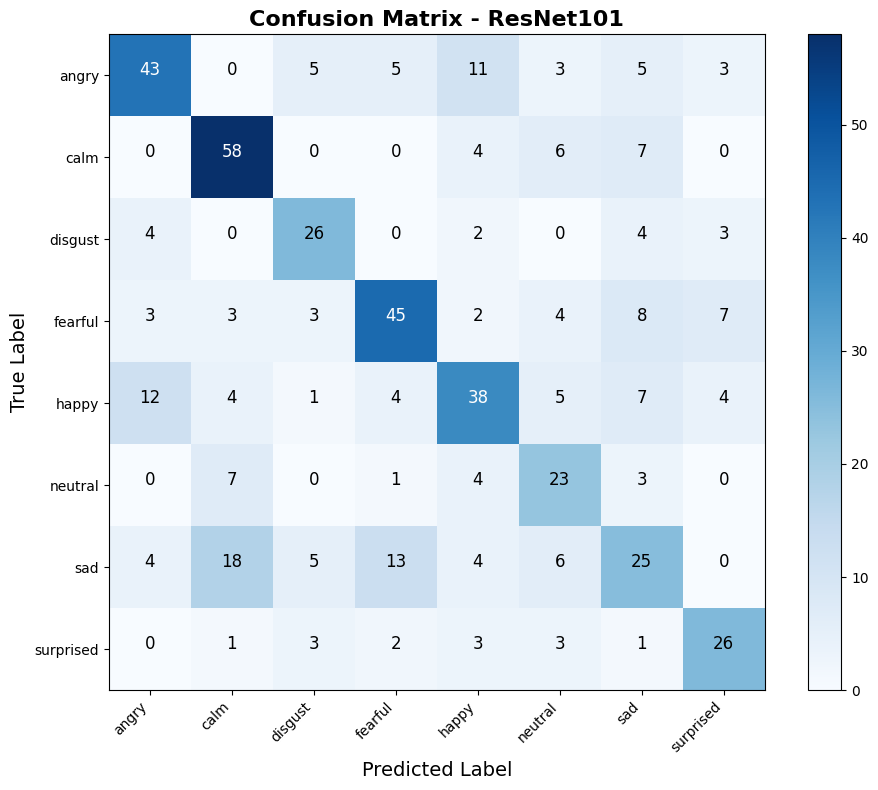


Detailed Classification Report for ResNet101:
--------------------------------------------------
              precision  recall  f1-score   support
angry            0.6515  0.5733    0.6099   75.0000
calm             0.6374  0.7733    0.6988   75.0000
disgust          0.6047  0.6667    0.6341   39.0000
fearful          0.6429  0.6000    0.6207   75.0000
happy            0.5588  0.5067    0.5315   75.0000
neutral          0.4600  0.6053    0.5227   38.0000
sad              0.4167  0.3333    0.3704   75.0000
surprised        0.6047  0.6667    0.6341   39.0000
accuracy         0.5784  0.5784    0.5784    0.5784
macro avg        0.5721  0.5907    0.5778  491.0000
weighted avg     0.5757  0.5784    0.5737  491.0000

Per-Class Performance Analysis for ResNet101:
--------------------------------------------------
       Angry: Precision=0.652, Recall=0.573, F1=0.610, Support=75
        Calm: Precision=0.637, Recall=0.773, F1=0.699, Support=75
     Disgust: Precision=0.605, Recall=0.667, F1=

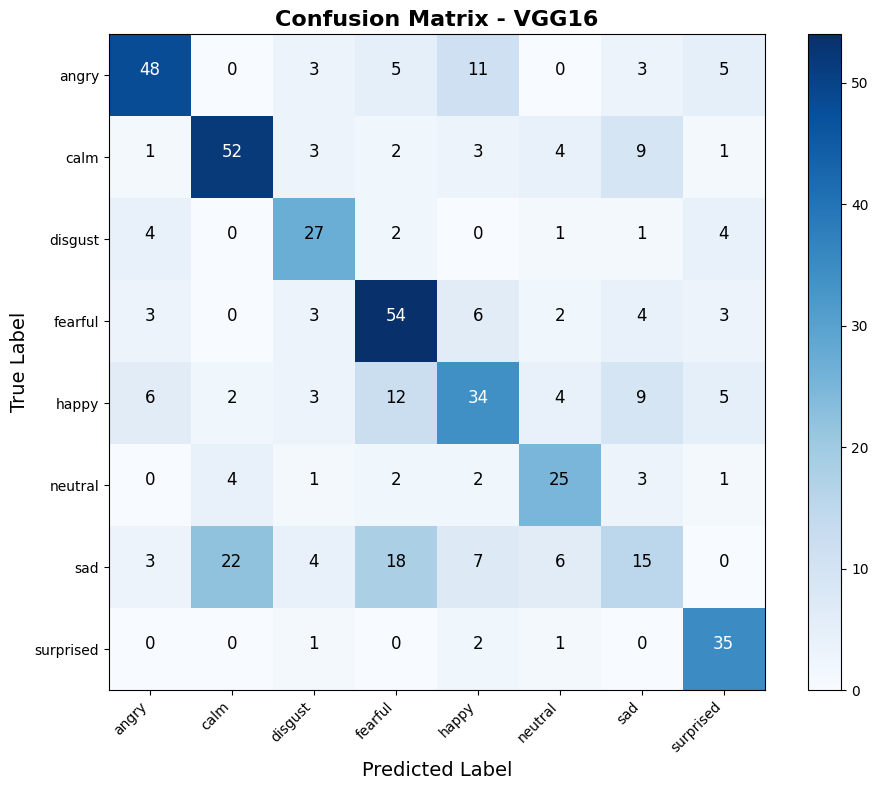


Detailed Classification Report for VGG16:
--------------------------------------------------
              precision  recall  f1-score   support
angry            0.7385  0.6400    0.6857   75.0000
calm             0.6500  0.6933    0.6710   75.0000
disgust          0.6000  0.6923    0.6429   39.0000
fearful          0.5684  0.7200    0.6353   75.0000
happy            0.5231  0.4533    0.4857   75.0000
neutral          0.5814  0.6579    0.6173   38.0000
sad              0.3409  0.2000    0.2521   75.0000
surprised        0.6481  0.8974    0.7527   39.0000
accuracy         0.5906  0.5906    0.5906    0.5906
macro avg        0.5813  0.6193    0.5928  491.0000
weighted avg     0.5750  0.5906    0.5756  491.0000

Per-Class Performance Analysis for VGG16:
--------------------------------------------------
       Angry: Precision=0.738, Recall=0.640, F1=0.686, Support=75
        Calm: Precision=0.650, Recall=0.693, F1=0.671, Support=75
     Disgust: Precision=0.600, Recall=0.692, F1=0.643, S

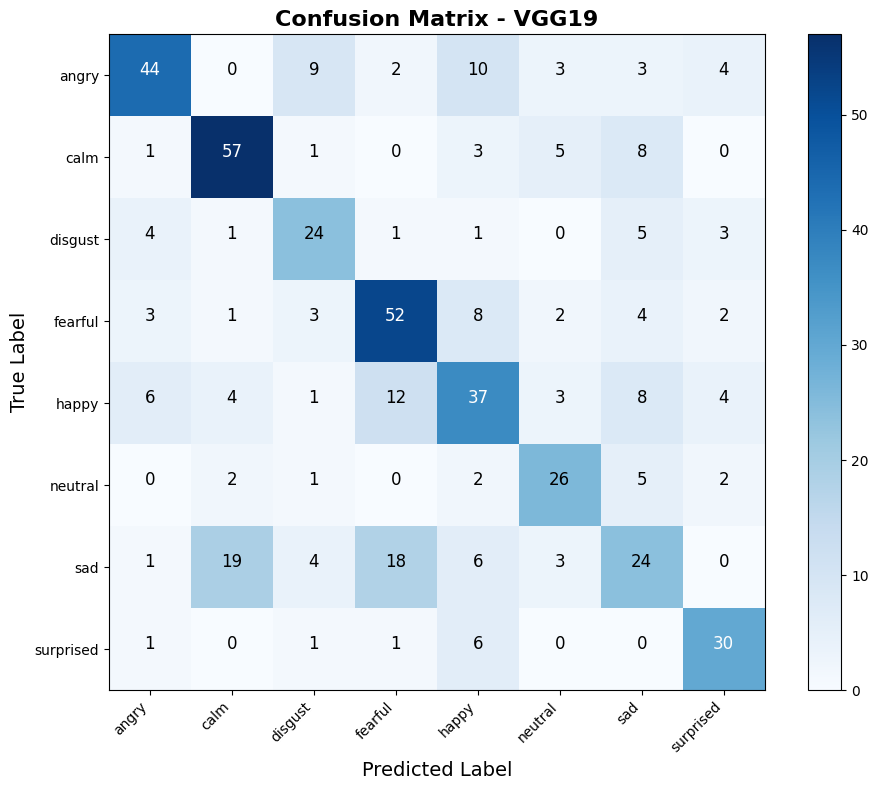


Detailed Classification Report for VGG19:
--------------------------------------------------
              precision  recall  f1-score   support
angry            0.7333  0.5867    0.6519   75.0000
calm             0.6786  0.7600    0.7170   75.0000
disgust          0.5455  0.6154    0.5783   39.0000
fearful          0.6047  0.6933    0.6460   75.0000
happy            0.5068  0.4933    0.5000   75.0000
neutral          0.6190  0.6842    0.6500   38.0000
sad              0.4211  0.3200    0.3636   75.0000
surprised        0.6667  0.7692    0.7143   39.0000
accuracy         0.5988  0.5988    0.5988    0.5988
macro avg        0.5970  0.6153    0.6026  491.0000
weighted avg     0.5940  0.5988    0.5927  491.0000

Per-Class Performance Analysis for VGG19:
--------------------------------------------------
       Angry: Precision=0.733, Recall=0.587, F1=0.652, Support=75
        Calm: Precision=0.679, Recall=0.760, F1=0.717, Support=75
     Disgust: Precision=0.545, Recall=0.615, F1=0.578, S

In [32]:
# Store all model results
model_results = {}
print("Loading best ResNet101...")
resnet101_model.load_weights('/content/optimal_resnet101_weights.h5')
model_results['ResNet101'] = evaluate_model_performance(
    resnet101_model, test_resnet_features, categorical_test_labels,
    encoded_test_labels, 'ResNet101', emotion_encoder.classes_
)
# Evaluate VGG16 Model
print("Loading best VGG16 model...")
vgg16_model.load_weights('/content/optimal_vgg16_weights.h5')
vgg16_results = evaluate_model_performance(
    vgg16_model,
    test_resnet_features,
    categorical_test_labels,
    encoded_test_labels,
    'VGG16',
    emotion_encoder.classes_
)
model_results['VGG16'] = vgg16_results

# Evaluate VGG19 Model
print("Loading best VGG19 model...")
vgg19_model.load_weights('/content/optimal_vgg19_weights.h5')
vgg19_results = evaluate_model_performance(
    vgg19_model,
    test_resnet_features,
    categorical_test_labels,
    encoded_test_labels,
    'VGG19',
    emotion_encoder.classes_
)
model_results['VGG19'] = vgg19_results


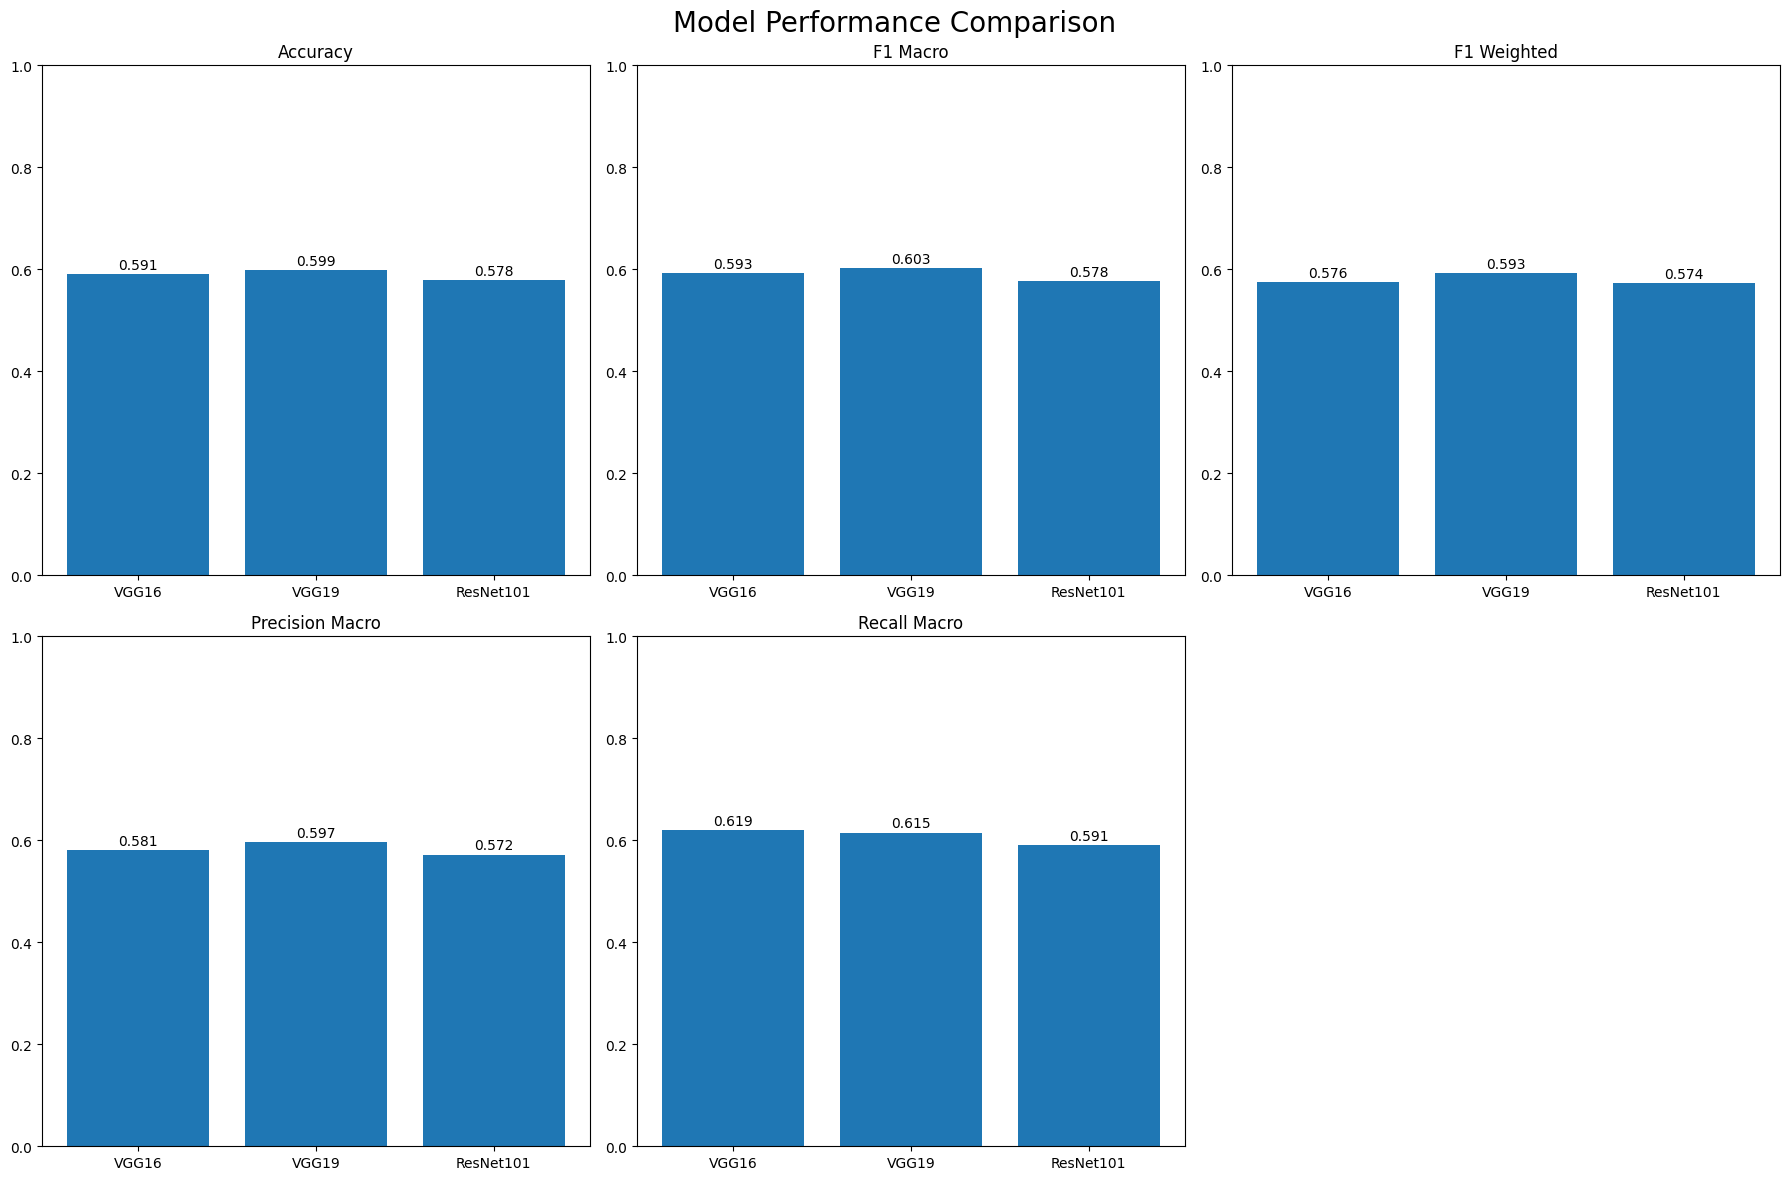


Model Performance Summary:
            accuracy  f1_macro f1_weighted precision_macro recall_macro  \
VGG16      0.590631  0.592828    0.575596        0.581302     0.619288   
VGG19      0.598778  0.602629    0.592655        0.596953      0.61527   
ResNet101  0.578411  0.577784    0.573668        0.572066     0.590658   

                                            confusion_matrix  \
VGG16      [[48, 0, 3, 5, 11, 0, 3, 5], [1, 52, 3, 2, 3, ...   
VGG19      [[44, 0, 9, 2, 10, 3, 3, 4], [1, 57, 1, 0, 3, ...   
ResNet101  [[43, 0, 5, 5, 11, 3, 5, 3], [0, 58, 0, 0, 4, ...   

                                       classification_report  \
VGG16      {'angry': {'precision': 0.7384615384615385, 'r...   
VGG19      {'angry': {'precision': 0.7333333333333333, 'r...   
ResNet101  {'angry': {'precision': 0.6515151515151515, 'r...   

                                                 predictions  \
VGG16      [[0.7803912, 0.00021562562, 0.0006741107, 0.03...   
VGG19      [[0.84259224, 0.00044

In [35]:
def create_model_comparison_chart(results):
    metrics = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro']
    # Data extraction
    v16 = [model_results['VGG16'][m] for m in metrics]
    v19 = [model_results['VGG19'][m] for m in metrics]
    r101 = [model_results['ResNet101'][m] for m in metrics]
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Performance Comparison', fontsize=20)
    for idx, metric in enumerate(metrics):
        ax = axes[idx//3, idx%3]
        scores = [v16[idx], v19[idx], r101[idx]]
        bars = ax.bar(['VGG16', 'VGG19', 'ResNet101'], scores)
        ax.set_title(metric.replace('_', ' ').title())
        ax.set_ylim(0, 1)
        for bar in bars:
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
                    f"{bar.get_height():.3f}", ha='center')
    axes[1,2].axis('off')
    plt.tight_layout(); plt.show()
    # Summary table
    summary_df = pd.DataFrame({
        'VGG16': model_results['VGG16'],
        'VGG19': model_results['VGG19'],
        'ResNet101': model_results['ResNet101']
    }).T.round(4)
    print("\nModel Performance Summary:\n", summary_df)
    return summary_df

comparison_summary = create_model_comparison_chart(model_results)


In [36]:
import pickle

# Save trained models
vgg16_model.save('final_vgg16_emotion_model.h5')
vgg19_model.save('final_vgg19_emotion_model.h5')
resnet101_model.save('final_resnet101_emotion_model.h5')

# Save label encoder
with open('emotion_label_encoder.pkl', 'wb') as f:
    pickle.dump(emotion_encoder, f)

# Save feature extractor
with open('audio_feature_extractor.pkl', 'wb') as f:
    pickle.dump(audio_processor, f)

# Save model results
with open('model_evaluation_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

print("✓ All models and results saved successfully!")


✓ All models and results saved successfully!


In [37]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import soundfile as sf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import io
import os
import tempfile
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Page configuration
st.set_page_config(
    page_title="🎭 Audio Emotion Recognition",
    page_icon="🎭",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.1);
    }
    .sub-header {
        font-size: 1.5rem;
        color: #2c3e50;
        margin-bottom: 1rem;
    }
    .metric-card {
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        text-align: center;
        margin: 0.5rem 0;
    }
    .prediction-box {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 2rem;
        border-radius: 15px;
        color: white;
        text-align: center;
        margin: 1rem 0;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }
    .stButton > button {
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        color: white;
        border: none;
        border-radius: 20px;
        padding: 0.5rem 2rem;
        font-weight: bold;
        transition: all 0.3s ease;
    }
    .stButton > button:hover {
        transform: translateY(-2px);
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
    }
</style>
""", unsafe_allow_html=True)

# Enhanced Audio Feature Extractor Class (from your code)
class EnhancedAudioFeatureExtractor:
    def __init__(self, sampling_rate=22050, audio_duration=3.0, mfcc_coefficients=13, mel_bands=64):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.mfcc_coefficients = mfcc_coefficients
        self.mel_bands = mel_bands
        self.target_length = int(sampling_rate * audio_duration)

    def load_and_normalize_audio(self, audio_path, noise_reduction=False):
        """Load and normalize audio with optional noise reduction"""
        try:
            audio_signal, sr = librosa.load(audio_path, sr=self.sampling_rate, duration=self.audio_duration)

            if len(audio_signal) < self.target_length:
                audio_signal = np.pad(audio_signal, (0, self.target_length - len(audio_signal)), mode='constant')
            else:
                audio_signal = audio_signal[:self.target_length]

            audio_signal = librosa.util.normalize(audio_signal)
            return audio_signal, sr

        except Exception as error:
            st.error(f"Audio loading error: {error}")
            return np.zeros(self.target_length), self.sampling_rate

    def generate_mel_spectrogram(self, audio_path):
        """Generate mel-spectrogram for CNN processing"""
        audio_signal, sr = self.load_and_normalize_audio(audio_path)

        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_signal, sr=sr, n_mels=self.mel_bands, fmax=8000
        )
        mel_spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        normalized_mel_spec = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        return normalized_mel_spec

@st.cache_resource
def load_models_and_encoders():
    """Load pre-trained models and encoders (cached for performance)"""
    try:
        # Load models
        vgg16_model = load_model('final_vgg16_emotion_model.h5')
        vgg19_model = load_model('final_vgg19_emotion_model.h5')
        resnet101_model = load_model('final_resnet101_emotion_model.h5')

        # Load label encoder
        with open('emotion_label_encoder.pkl', 'rb') as f:
            emotion_encoder = pickle.load(f)

        # Load feature extractor
        with open('audio_feature_extractor.pkl', 'rb') as f:
            feature_extractor = pickle.load(f)

        return {
            'VGG16': vgg16_model,
            'VGG19': vgg19_model,
            'ResNet101': resnet101_model,
            'encoder': emotion_encoder,
            'extractor': feature_extractor
        }
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None

def resize_for_resnet(spectrogram_data, target_dimensions=(224, 224)):
    """Resize spectrograms for ResNet input"""
    from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

    # Convert to RGB format
    rgb_data = np.repeat(spectrogram_data[..., np.newaxis], 3, axis=-1)

    # Resize
    image = array_to_img(rgb_data)
    resized_image = image.resize(target_dimensions)
    image_array = img_to_array(resized_image)

    return np.expand_dims(image_array / 255.0, axis=0)

def predict_emotion(audio_file, models_dict, selected_model):
    """Predict emotion from audio file"""
    try:
        # Save uploaded file temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp_file:
            tmp_file.write(audio_file.read())
            tmp_file_path = tmp_file.name

        # Extract features
        feature_extractor = models_dict['extractor']
        mel_spec = feature_extractor.generate_mel_spectrogram(tmp_file_path)

        # Prepare input for selected model
        resized_input = resize_for_resnet(mel_spec)

        # Get model and make prediction
        model = models_dict[selected_model]
        prediction = model.predict(resized_input)

        # Get emotion labels and probabilities
        emotion_encoder = models_dict['encoder']
        predicted_class = np.argmax(prediction)
        predicted_emotion = emotion_encoder.inverse_transform([predicted_class])[0]
        confidence = np.max(prediction) * 100

        # Get all probabilities for visualization
        all_probabilities = prediction[0]
        emotion_probs = {
            emotion_encoder.inverse_transform([i])[0]: prob * 100
            for i, prob in enumerate(all_probabilities)
        }

        # Clean up temporary file
        os.unlink(tmp_file_path)

        return predicted_emotion, confidence, emotion_probs, mel_spec

    except Exception as e:
        st.error(f"Prediction error: {e}")
        return None, None, None, None

def create_visualizations(mel_spec, emotion_probs, audio_file):
    """Create visualization plots"""
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("🎵 Mel-Spectrogram")
        fig, ax = plt.subplots(figsize=(10, 6))
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel')
        ax.set_title('Mel-Spectrogram', fontsize=14, fontweight='bold')
        plt.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB')
        st.pyplot(fig)

    with col2:
        st.subheader("📊 Emotion Probabilities")
        emotions = list(emotion_probs.keys())
        probabilities = list(emotion_probs.values())

        # Create interactive bar chart
        fig = px.bar(
            x=emotions,
            y=probabilities,
            title="Emotion Prediction Confidence",
            labels={'x': 'Emotions', 'y': 'Confidence (%)'},
            color=probabilities,
            color_continuous_scale='viridis'
        )
        fig.update_layout(
            title_font_size=16,
            title_x=0.5,
            showlegend=False
        )
        st.plotly_chart(fig, use_container_width=True)

def main():
    # Header
    st.markdown('<h1 class="main-header">🎭 Audio Emotion Recognition System</h1>', unsafe_allow_html=True)
    st.markdown('<p style="text-align: center; font-size: 1.2rem; color: #666;">Advanced AI-powered emotion detection from audio using deep learning models</p>', unsafe_allow_html=True)

    # Load models
    with st.spinner("🔄 Loading AI models..."):
        models_dict = load_models_and_encoders()

    if models_dict is None:
        st.error("❌ Failed to load models. Please ensure all model files are present.")
        st.stop()

    st.success("✅ Models loaded successfully!")

    # Sidebar
    st.sidebar.header("🎛️ Configuration")

    # Model selection
    selected_model = st.sidebar.selectbox(
        "🤖 Select AI Model",
        ["VGG16", "VGG19", "ResNet101"],
        help="Choose the deep learning model for emotion prediction"
    )

    # Model info
    model_info = {
        "VGG16": "Visual Geometry Group 16-layer network optimized for image classification",
        "VGG19": "Enhanced VGG with 19 layers for improved feature extraction",
        "ResNet101": "Residual Network with 101 layers and skip connections"
    }

    st.sidebar.info(f"**Selected Model:** {selected_model}\n\n{model_info[selected_model]}")

    # Main content
    st.markdown('<h2 class="sub-header">🎤 Upload Audio File</h2>', unsafe_allow_html=True)

    uploaded_file = st.file_uploader(
        "Choose an audio file",
        type=['wav', 'mp3', 'flac', 'm4a'],
        help="Upload an audio file to analyze emotions. Supported formats: WAV, MP3, FLAC, M4A"
    )

    if uploaded_file is not None:
        # Display file info
        col1, col2, col3 = st.columns(3)
        with col1:
            st.markdown(f'<div class="metric-card"><strong>📁 File:</strong><br>{uploaded_file.name}</div>', unsafe_allow_html=True)
        with col2:
            st.markdown(f'<div class="metric-card"><strong>📏 Size:</strong><br>{uploaded_file.size / 1024:.1f} KB</div>', unsafe_allow_html=True)
        with col3:
            st.markdown(f'<div class="metric-card"><strong>🎭 Model:</strong><br>{selected_model}</div>', unsafe_allow_html=True)

        # Audio player
        st.markdown('<h3 class="sub-header">🔊 Audio Preview</h3>', unsafe_allow_html=True)
        st.audio(uploaded_file, format='audio/wav')

        # Predict button
        if st.button("🚀 Analyze Emotion", type="primary"):
            with st.spinner(f"🧠 Analyzing audio with {selected_model} model..."):
                # Reset file pointer
                uploaded_file.seek(0)

                # Make prediction
                predicted_emotion, confidence, emotion_probs, mel_spec = predict_emotion(
                    uploaded_file, models_dict, selected_model
                )

                if predicted_emotion is not None:
                    # Display results
                    st.markdown('<h2 class="sub-header">🎯 Prediction Results</h2>', unsafe_allow_html=True)

                    # Main prediction display
                    st.markdown(f'''
                    <div class="prediction-box">
                        <h2>🎭 Detected Emotion</h2>
                        <h1 style="font-size: 3rem; margin: 1rem 0;">{predicted_emotion.upper()}</h1>
                        <h3>Confidence: {confidence:.1f}%</h3>
                    </div>
                    ''', unsafe_allow_html=True)

                    # Detailed results
                    col1, col2 = st.columns([1, 1])

                    with col1:
                        st.markdown("### 📈 All Emotion Scores")
                        for emotion, prob in sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True):
                            st.progress(prob/100, text=f"{emotion.capitalize()}: {prob:.1f}%")

                    with col2:
                        st.markdown("### 🔍 Analysis Details")
                        st.write(f"**Primary Emotion:** {predicted_emotion.capitalize()}")
                        st.write(f"**Confidence Level:** {confidence:.2f}%")
                        st.write(f"**Model Used:** {selected_model}")
                        st.write(f"**Audio Duration:** 3.0 seconds (normalized)")

                    # Visualizations
                    st.markdown('<h2 class="sub-header">📊 Detailed Analysis</h2>', unsafe_allow_html=True)
                    create_visualizations(mel_spec, emotion_probs, uploaded_file)

                    # Emotion interpretation
                    st.markdown('<h3 class="sub-header">💡 Emotion Insights</h3>', unsafe_allow_html=True)

                    emotion_descriptions = {
                        'happy': '😊 Positive, joyful, and uplifting emotional state',
                        'sad': '😢 Melancholic, sorrowful, or downcast emotional state',
                        'angry': '😠 Frustrated, irritated, or aggressive emotional state',
                        'fearful': '😨 Anxious, worried, or apprehensive emotional state',
                        'surprised': '😲 Shocked, amazed, or unexpected reaction',
                        'disgusted': '🤢 Repulsed, revolted, or disgusted reaction',
                        'neutral': '😐 Calm, balanced, or emotionally neutral state',
                        'calm': '😌 Peaceful, relaxed, and serene emotional state'
                    }

                    description = emotion_descriptions.get(predicted_emotion.lower(), 'Emotional state detected')
                    st.info(f"**{predicted_emotion.capitalize()}:** {description}")

    # Footer
    st.markdown("---")
    st.markdown("""
    <div style="text-align: center; color: #666; padding: 2rem;">
        <p>🎭 Audio Emotion Recognition System</p>
        <p>Powered by Deep Learning | Built with Streamlit</p>
        <p>Models: VGG16, VGG19, ResNet101 | Dataset: RAVDESS</p>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()

In [38]:
# Run this in your next Jupyter cell to create the Streamlit app
streamlit_app_code = '''
import streamlit as st
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import tempfile
import os
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Page configuration
st.set_page_config(
    page_title="Audio Emotion Recognition",
    page_icon="🎵",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
        font-weight: bold;
    }
    .sub-header {
        font-size: 1.5rem;
        color: #ff7f0e;
        margin: 1rem 0;
    }
    .metric-card {
        background-color: #f0f2f6;
        padding: 1rem;
        border-radius: 10px;
        border-left: 5px solid #1f77b4;
    }
    .prediction-result {
        font-size: 2rem;
        color: #2e8b57;
        text-align: center;
        font-weight: bold;
        padding: 1rem;
        background-color: #f0f8ff;
        border-radius: 10px;
        margin: 1rem 0;
    }
</style>
""", unsafe_allow_html=True)

# Enhanced Audio Feature Extractor Class
class EnhancedAudioFeatureExtractor:
    def _init_(self, sampling_rate=22050, audio_duration=3.0, mfcc_coefficients=13, mel_bands=64):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.mfcc_coefficients = mfcc_coefficients
        self.mel_bands = mel_bands
        self.target_length = int(sampling_rate * audio_duration)

    def load_and_normalize_audio(self, audio_path, noise_reduction=False):
        """Load and normalize audio with optional noise reduction"""
        try:
            audio_signal, sr = librosa.load(audio_path, sr=self.sampling_rate, duration=self.audio_duration)

            if len(audio_signal) < self.target_length:
                audio_signal = np.pad(audio_signal, (0, self.target_length - len(audio_signal)), mode='constant')
            else:
                audio_signal = audio_signal[:self.target_length]

            audio_signal = librosa.util.normalize(audio_signal)
            return audio_signal, sr
        except Exception as error:
            st.error(f"Audio loading error: {error}")
            return np.zeros(self.target_length), self.sampling_rate

    def generate_mel_spectrogram(self, audio_path):
        """Generate mel-spectrogram for CNN processing"""
        audio_signal, sr = self.load_and_normalize_audio(audio_path)

        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_signal, sr=sr, n_mels=self.mel_bands, fmax=8000
        )
        mel_spec_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        normalized_mel_spec = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

        return normalized_mel_spec

def resize_spectrograms_for_resnet(spectrogram_data, target_dimensions=(224, 224)):
    """Resize spectrograms for ResNet input requirements"""
    from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

    # Convert to RGB format
    spectrogram_rgb = np.repeat(spectrogram_data[..., np.newaxis], 3, axis=-1)

    # Convert to PIL Image and resize
    image = array_to_img(spectrogram_rgb)
    resized_image = image.resize(target_dimensions)
    image_array = img_to_array(resized_image)

    return np.expand_dims(image_array / 255.0, axis=0)  # Normalize and add batch dimension

@st.cache_resource
def load_models_and_encoders():
    """Load all trained models and encoders"""
    try:
        models = {}

        # Load models (you'll need to update these paths)
        if os.path.exists('final_vgg16_emotion_model.h5'):
            models['VGG16'] = load_model('final_vgg16_emotion_model.h5')
        if os.path.exists('final_vgg19_emotion_model.h5'):
            models['VGG19'] = load_model('final_vgg19_emotion_model.h5')
        if os.path.exists('final_resnet101_emotion_model.h5'):
            models['ResNet101'] = load_model('final_resnet101_emotion_model.h5')

        # Load label encoder
        with open('emotion_label_encoder.pkl', 'rb') as f:
            label_encoder = pickle.load(f)

        # Load feature extractor
        with open('audio_feature_extractor.pkl', 'rb') as f:
            feature_extractor = pickle.load(f)

        return models, label_encoder, feature_extractor
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return {}, None, None

def plot_waveform(audio_signal, sr):
    """Plot audio waveform"""
    fig, ax = plt.subplots(figsize=(12, 4))
    time = np.linspace(0, len(audio_signal) / sr, len(audio_signal))
    ax.plot(time, audio_signal, color='#1f77b4', linewidth=0.8)
    ax.set_title('Audio Waveform', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

def plot_spectrogram(mel_spec, sr):
    """Plot mel-spectrogram"""
    fig, ax = plt.subplots(figsize=(12, 6))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', ax=ax, cmap='viridis')
    ax.set_title('Mel-Spectrogram', fontsize=14, fontweight='bold')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    return fig

def plot_predictions(predictions, emotion_classes):
    """Plot prediction probabilities"""
    fig = go.Figure(data=[
        go.Bar(
            x=emotion_classes,
            y=predictions[0],
            marker_color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#fdd835', '#ff8a65', '#ba68c8', '#81c784'],
            text=[f'{p:.3f}' for p in predictions[0]],
            textposition='auto',
        )
    ])

    fig.update_layout(
        title='Emotion Prediction Probabilities',
        xaxis_title='Emotions',
        yaxis_title='Probability',
        height=500,
        showlegend=False
    )

    return fig

def main():
    # Header
    st.markdown('<h1 class="main-header"> Audio Emotion Recognition System</h1>', unsafe_allow_html=True)

    # Load models and encoders
    models, label_encoder, feature_extractor = load_models_and_encoders()

    if not models or label_encoder is None:
        st.error("⚠ Models not found! Please ensure all model files are in the correct directory.")
        st.info("Required files: final_vgg16_emotion_model.h5, final_vgg19_emotion_model.h5, final_resnet101_emotion_model.h5, emotion_label_encoder.pkl, audio_feature_extractor.pkl")
        return

    # Sidebar
    st.sidebar.markdown("## 🎛 Configuration")
    selected_model = st.sidebar.selectbox(
        "Select Model",
        list(models.keys()),
        help="Choose which pre-trained model to use for prediction"
    )

    show_visualizations = st.sidebar.checkbox(
        "Show Audio Visualizations",
        value=True,
        help="Display waveform and spectrogram plots"
    )

    show_probabilities = st.sidebar.checkbox(
        "Show Prediction Probabilities",
        value=True,
        help="Display probability scores for all emotions"
    )

    # Main content
    st.markdown('<h2 class="sub-header"> Upload Audio File</h2>', unsafe_allow_html=True)

    uploaded_file = st.file_uploader(
        "Choose an audio file (WAV, MP3, MP4)",
        type=['wav', 'mp3', 'mp4'],
        help="Upload an audio file containing speech or song for emotion recognition"
    )

    if uploaded_file is not None:
        # Save uploaded file temporarily
        with tempfile.NamedTemporaryFile(delete=False, suffix=f".{uploaded_file.name.split('.')[-1]}") as tmp_file:
            tmp_file.write(uploaded_file.read())
            temp_path = tmp_file.name

        try:
            # Display file info
            col1, col2, col3 = st.columns(3)
            with col1:
                st.metric("File Name", uploaded_file.name)
            with col2:
                st.metric("File Size", f"{uploaded_file.size / 1024:.1f} KB")
            with col3:
                st.metric("Selected Model", selected_model)

            # Audio player
            st.markdown('<h2 class="sub-header"> Audio Player</h2>', unsafe_allow_html=True)
            st.audio(uploaded_file)

            # Process audio
            with st.spinner('Processing audio and extracting features...'):
                # Initialize feature extractor if not loaded
                if feature_extractor is None:
                    feature_extractor = EnhancedAudioFeatureExtractor()

                # Extract features
                mel_spec = feature_extractor.generate_mel_spectrogram(temp_path)
                audio_signal, sr = feature_extractor.load_and_normalize_audio(temp_path)

                # Prepare input for model
                resized_features = resize_spectrograms_for_resnet(mel_spec)

                # Make prediction
                model = models[selected_model]
                predictions = model.predict(resized_features, verbose=0)
                predicted_class_idx = np.argmax(predictions[0])
                predicted_emotion = label_encoder.classes_[predicted_class_idx]
                confidence = predictions[0][predicted_class_idx]

            # Display prediction result
            st.markdown('<h2 class="sub-header"> Prediction Result</h2>', unsafe_allow_html=True)

            result_col1, result_col2 = st.columns(2)
            with result_col1:
                st.markdown(
                    f'<div class="prediction-result"> {predicted_emotion.upper()}</div>',
                    unsafe_allow_html=True
                )
            with result_col2:
                st.metric(
                    "Confidence Score",
                    f"{confidence:.3f}",
                    f"{confidence*100:.1f}%"
                )

            # Show prediction probabilities
            if show_probabilities:
                st.markdown('<h2 class="sub-header"> Prediction Probabilities</h2>', unsafe_allow_html=True)
                prob_fig = plot_predictions(predictions, label_encoder.classes_)
                st.plotly_chart(prob_fig, use_container_width=True)

                # Probability table
                prob_df = pd.DataFrame({
                    'Emotion': label_encoder.classes_,
                    'Probability': predictions[0],
                    'Percentage': predictions[0] * 100
                }).sort_values('Probability', ascending=False)

                st.dataframe(prob_df.style.format({'Probability': '{:.4f}', 'Percentage': '{:.2f}%'}))

            # Show visualizations
            if show_visualizations:
                st.markdown('<h2 class="sub-header"> Audio Visualizations</h2>', unsafe_allow_html=True)

                viz_col1, viz_col2 = st.columns(2)

                with viz_col1:
                    st.subheader("Waveform")
                    waveform_fig = plot_waveform(audio_signal, sr)
                    st.pyplot(waveform_fig)

                with viz_col2:
                    st.subheader("Mel-Spectrogram")
                    spec_fig = plot_spectrogram(mel_spec, sr)
                    st.pyplot(spec_fig)

        except Exception as e:
            st.error(f"Error processing audio: {e}")

        finally:
            # Clean up temporary file
            if os.path.exists(temp_path):
                os.unlink(temp_path)

    # Information section
    with st.expander("ℹ About This Application"):
        st.markdown("""
        ### Audio Emotion Recognition System

        This application uses deep learning models to recognize emotions from audio files.

        *Supported Emotions:*
        - 😐 Neutral
        - 😌 Calm
        - 😊 Happy
        - 😢 Sad
        - 😠 Angry
        - 😨 Fearful
        - 🤢 Disgust
        - 😲 Surprised

        *Available Models:*
        - *VGG16*: Lightweight CNN model, fast inference
        - *VGG19*: Deeper CNN model, balanced performance
        - *ResNet101*: Advanced CNN with residual connections, highest accuracy

        *Usage Instructions:*
        1. Select your preferred model from the sidebar
        2. Upload an audio file (WAV, MP3, or MP4)
        3. View the emotion prediction and confidence score
        4. Explore visualizations and probability distributions
        """)

    # Footer
    st.markdown("---")
    st.markdown(
        "<div style='text-align: center; color: #666;'>Built with Streamlit • Powered by TensorFlow</div>",
        unsafe_allow_html=True
    )

if _name_ == "_main_":
    main()
'''

# Write the Streamlit app to a file
with open('app.py', 'w') as f:
    f.write(streamlit_app_code)

print(" Streamlit app created successfully as 'app.py'")
print("Next steps:")
print("1. Create requirements.txt file")
print("2. Set up project structure")
print("3. Test locally")
print("4. Deploy to Streamlit Cloud")

 Streamlit app created successfully as 'app.py'
Next steps:
1. Create requirements.txt file
2. Set up project structure
3. Test locally
4. Deploy to Streamlit Cloud


In [39]:
# Create requirements.txt in your next cell
requirements_content = '''
streamlit==1.28.0
tensorflow==2.13.0
librosa==0.10.1
pandas==2.0.3
numpy==1.24.3
matplotlib==3.7.2
seaborn==0.12.2
plotly==5.15.0
scikit-learn==1.3.0
soundfile==0.12.1
Pillow==10.0.0
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

print(" Requirements.txt created successfully")

 Requirements.txt created successfully


In [40]:
# Run this in your next Jupyter cell to set up project structure
import os
import shutil

def setup_project_structure():
    """Set up the project directory structure"""

    # Create main project directory
    project_name = "audio-emotion-recognition"

    if not os.path.exists(project_name):
        os.makedirs(project_name)

    # Create subdirectories
    directories = [
        "models",
        "utils",
        "assets",
        "docs"
    ]

    for dir_name in directories:
        dir_path = os.path.join(project_name, dir_name)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    # Move files to appropriate locations
    files_to_move = {
        'app.py': project_name,
        'requirements.txt': project_name,
        'final_vgg16_emotion_model.h5': os.path.join(project_name, 'models'),
        'final_vgg19_emotion_model.h5': os.path.join(project_name, 'models'),
        'final_resnet101_emotion_model.h5': os.path.join(project_name, 'models'),
        'emotion_label_encoder.pkl': os.path.join(project_name, 'models'),
        'audio_feature_extractor.pkl': os.path.join(project_name, 'models'),
    }

    for file_name, destination in files_to_move.items():
        if os.path.exists(file_name):
            dest_path = os.path.join(destination, file_name) if destination != project_name else os.path.join(destination, file_name)
            shutil.copy2(file_name, dest_path)
            print(f"✅ Copied {file_name} to {destination}")
        else:
            print(f"⚠ {file_name} not found")

    # Create README.md
    readme_content = '''# Audio Emotion Recognition System

A deep learning-based web application for recognizing emotions from audio files using pre-trained CNN models.

## Features

- 🎵 Support for multiple audio formats (WAV, MP3, MP4)
- 🤖 Three pre-trained models: VGG16, VGG19, ResNet101
- 😊 Recognition of 8 emotions: neutral, calm, happy, sad, angry, fearful, disgust, surprised
- 📊 Interactive visualizations and probability distributions
- 🎛 User-friendly web interface built with Streamlit

## Installation

1. Clone the repository:
bash
git clone https://github.com/yourusername/audio-emotion-recognition.git
cd audio-emotion-recognition


2. Install dependencies:
bash
pip install -r requirements.txt


3. Run the application:
bash
streamlit run app.py


## Usage

1. Select a model from the sidebar
2. Upload an audio file
3. View emotion prediction results
4. Explore audio visualizations and probability scores

## Models

- *VGG16*: Fast and efficient for real-time applications
- *VGG19*: Balanced performance and accuracy
- *ResNet101*: Highest accuracy with advanced residual connections

## Dataset

Trained on the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset.

## Technologies Used

- TensorFlow/Keras for deep learning
- Streamlit for web interface
- Librosa for audio processing
- Plotly for interactive visualizations

## License

MIT License
'''

    with open(os.path.join(project_name, 'README.md'), 'w') as f:
        f.write(readme_content)

    # Create .gitignore
    gitignore_content = '''# Python
_pycache_/
*.py[cod]
*$py.class
*.so
.Python
build/
develop-eggs/
dist/
downloads/
eggs/
.eggs/
lib/
lib64/
parts/
sdist/
var/
wheels/
*.egg-info/
.installed.cfg
*.egg

# Virtual Environment
venv/
ENV/
env/

# Jupyter Notebook
.ipynb_checkpoints

# IDEs
.vscode/
.idea/
*.swp
*.swo

# OS
.DS_Store
Thumbs.db

# Streamlit
.streamlit/

# Large model files (optional)
*.h5
*.pkl

# Temporary files
temp_*
'''

    with open(os.path.join(project_name, '.gitignore'), 'w') as f:
        f.write(gitignore_content)

    print(f"Project structure created in '{project_name}' directory")
    print("\nProject structure:")
    for root, dirs, files in os.walk(project_name):
        level = root.replace(project_name, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f"{subindent}{file}")

# Run the setup
setup_project_structure()

✅ Copied app.py to audio-emotion-recognition
✅ Copied requirements.txt to audio-emotion-recognition
✅ Copied final_vgg16_emotion_model.h5 to audio-emotion-recognition/models
✅ Copied final_vgg19_emotion_model.h5 to audio-emotion-recognition/models
✅ Copied final_resnet101_emotion_model.h5 to audio-emotion-recognition/models
✅ Copied emotion_label_encoder.pkl to audio-emotion-recognition/models
✅ Copied audio_feature_extractor.pkl to audio-emotion-recognition/models
Project structure created in 'audio-emotion-recognition' directory

Project structure:
audio-emotion-recognition/
  README.md
  app.py
  requirements.txt
  .gitignore
  models/
    final_resnet101_emotion_model.h5
    emotion_label_encoder.pkl
    final_vgg19_emotion_model.h5
    final_vgg16_emotion_model.h5
    audio_feature_extractor.pkl
  docs/
  assets/
  utils/
